# Laboratorio 1

- Daniel Alfredo Rayo Roldan
- Gerardo Pineda Riveiro

## Repo:
https://github.com/DanielRasho/DS-Lab1.git

In [877]:
# pip install openpyxl instalar esto
import rdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from varianceTest import Heteroskedasticity

## Cargado de datos

In [878]:
xls = pd.read_excel("./data/preciosLimpio.xlsx", sheet_name=None)

resultados = {}

for nombre_hoja, df in xls.items():
    hoja_df = pd.read_excel("./data/preciosLimpio.xlsx", sheet_name=nombre_hoja, header=7, usecols="A,C,D,E,F,G,H")
    resultados[nombre_hoja] = hoja_df

In [879]:
for nombre_hoja in resultados:
    df = resultados[nombre_hoja]
    resultados[nombre_hoja] = df.iloc[1:].reset_index(drop=True)

In [880]:
resultados["2024"]

,FECHA,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs.,Unnamed: 7
0,2024-01-01,30.44,28.95,29.47,18.99,115,4.6
1,2024-01-02,30.44,28.95,29.47,18.99,115,4.6
2,2024-01-03,30.47,28.97,29.48,18.99,115,4.6
3,2024-01-04,30.47,28.97,29.48,18.99,115,4.6
4,2024-01-05,30.47,28.97,29.48,18.99,115,4.6
...,...,...,...,...,...,...,...
361,2024-12-27,28.99,27.49,25.51,17.94,110,4.4
362,2024-12-28,28.99,27.49,25.51,17.94,110,4.4
363,2024-12-29,28.99,27.49,25.51,17.94,110,4.4
364,2024-12-30,28.95,27.45,25.47,18.74,110,4.4


In [881]:
df_final = pd.DataFrame()

for nombre_hoja, df in resultados.items():
    df["Año"] = nombre_hoja
    df_final = pd.concat([df_final, df], ignore_index=True)

In [882]:
df_final.drop(columns=["Bunker"], inplace=True)
df_final.set_index("FECHA", inplace=True)
df_final.sort_index(ascending=True, inplace=True)

In [883]:
df_final.rename(columns={"Glp Cilindro 25Lbs." : "Gas 25Lbs", "Unnamed: 7": "Gas 1Lb"}, inplace=True)
df_final["Month"] = df_final.index.month
df_final["Año"] = df_final["Año"].astype(int)
df_final["Superior"] = df_final["Superior"].astype(float)
df_final["Regular"] = df_final["Regular"].astype(float)
df_final["Diesel"] = df_final["Diesel"].astype(float)
df_final["Gas 25Lbs"] = df_final["Gas 25Lbs"].astype(float)
df_final["Gas 1Lb"] = df_final["Gas 1Lb"].astype(float)
df_final

,Superior,Regular,Diesel,Gas 25Lbs,Gas 1Lb,Año,Month
FECHA,,,,,,,
2021-01-01,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-02,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-03,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-04,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-05,21.91,21.11,17.61,99.0,3.96,2021,1
...,...,...,...,...,...,...,...
2025-07-09,30.98,29.49,27.00,120.0,4.80,2025,7
2025-07-10,30.98,29.49,27.00,120.0,4.80,2025,7
2025-07-11,30.98,29.49,27.00,120.0,4.80,2025,7


## Exploración de Datos

**Se decidió estudiar los precios de la Gasolina Super, Diésel y Gas Licuado entre 2021 y 2025**. Una primera inspección de los datos nos indicó que el recurso más caro son los cilindros de 25 Lbs de gas licuado (precio promedio Q121.38) seguido de lejos por la gasolina superior ( Q32.15 ) y diésel (Q28.40). 

In [884]:
# Basic info
print(df_final.info())
print(df_final.describe())

# Check for missing values
print(df_final.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1655 entries, 2021-01-01 to 2025-07-13
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Superior   1655 non-null   float64
 1   Regular    1655 non-null   float64
 2   Diesel     1655 non-null   float64
 3   Gas 25Lbs  1655 non-null   float64
 4   Gas 1Lb    1655 non-null   float64
 5   Año        1655 non-null   int64  
 6   Month      1655 non-null   int32  
dtypes: float64(5), int32(1), int64(1)
memory usage: 97.0 KB
None
          Superior      Regular       Diesel    Gas 25Lbs      Gas 1Lb  \
count  1655.000000  1655.000000  1655.000000  1655.000000  1655.000000   
mean     32.149142    30.841692    28.407299   121.387680     4.855571   
std       3.816833     3.611342     4.870410     9.020728     0.360928   
min      21.910000    21.110000    17.610000    99.000000     3.960000   
25%      29.510000    28.280000    25.440000   115.000000     4.600000   
50%   

A continuación se ve la serie de tiempo de precios de los combustibles, todas las series empiezan desde el 1 de enero de 2021, hasta el 13 de junio de 2025, siendo un total 1655 registros (1 registro diario). De la gráfica se pueden obtener algunas conclusiones:
- Los precios varian en escala de semanas, es decir, un precio de combustible suele estar unos cuantos dias/semanas/meses antes de cambiar a un nuevo valor.
- Se observa ciertos patrones de estacionalidad entre finales de 2021 y principios de 2023.
- El gas licuado es de todos el que mantiene el mismo precio en largos periodos de tiempo.

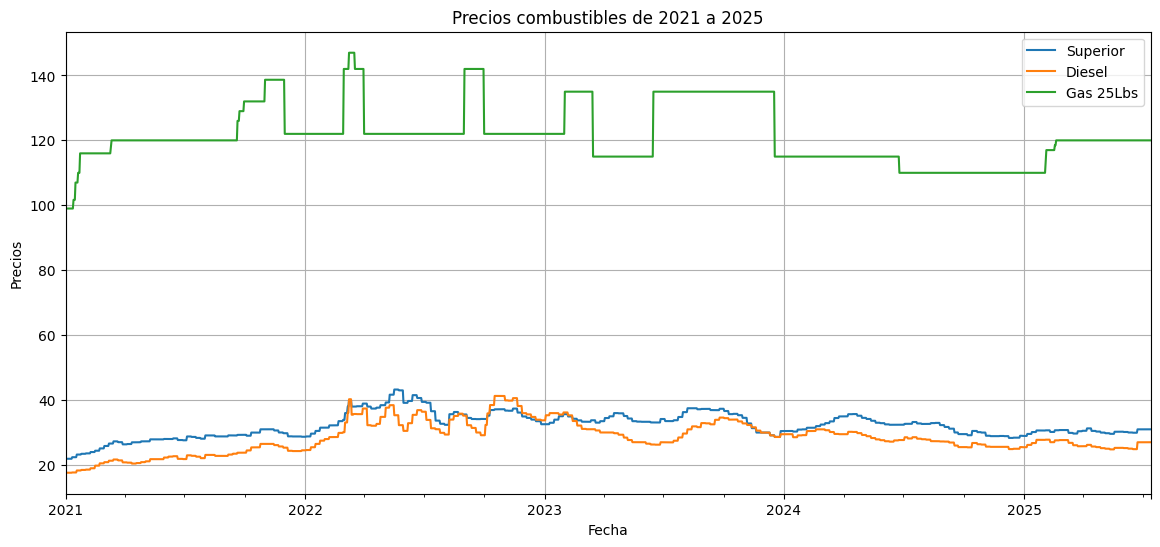

In [885]:
df_final.plot(figsize=(14, 6), y=['Superior', 'Diesel', 'Gas 25Lbs'], title="Precios combustibles de 2021 a 2025")
plt.ylabel("Precios")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

A continuación, también se condujo tests de normalidad sobre los precios de los combustibles, en ninguno de los casos se determinó que un combustible tuviera una distribución normal de precios, sino que era mucho más esporádico.

In [886]:
for col in ["Superior", "Diesel", "Gas 25Lbs"]:
    stat, p = shapiro(df_final[col].dropna())
    print(f"{col}: p = {p}")
    if p > 0.05:
        print("  -> Likely normal")
    else:
        print("  -> Not normal")

Superior: p = 3.9915074748457513e-10
  -> Not normal
Diesel: p = 4.887717605412204e-11
  -> Not normal
Gas 25Lbs: p = 3.252932875953924e-31
  -> Not normal


También se decidio estudiar los meses con precios promdio más alto a lo largo de los años, para descubrir si había alguna relación entre diferentes combustibles, sin embargo, a excepción de 2021 entre diesel y gasolina super, no hay coincidencia entre meses, es decir los incrementos en el precio de un combustible van de la mano con el aumento en el precio de los otros. La tabla a continuación resume los meses de mayor costo promedio para cada año y combustible:

In [887]:
monthly_avg = df_final.groupby(["Año", "Month"])[["Diesel", "Superior", "Gas 25Lbs"]].mean()
max_months = monthly_avg.groupby("Año").idxmax()
max_months

,Diesel,Superior,Gas 25Lbs
Año,,,
2021,"(2021, 11)","(2021, 11)","(2021, 11)"
2022,"(2022, 11)","(2022, 5)","(2022, 3)"
2023,"(2023, 1)","(2023, 8)","(2023, 2)"
2024,"(2024, 2)","(2024, 4)","(2024, 1)"
2025,"(2025, 2)","(2025, 7)","(2025, 3)"


Por último, en la misma linea de estudio sobre los picos en los precios, se calculo los 3 meses con mayores picos en cada año. Estas son las concluciones descubiertas:

- Diesel: De 2021 a 2022, tenia sus picos a finales de año, mientras que para el resto de años los picos ocurrian a principio de año.
- Gasolina: No hay una epoca del año común donde los precios aumenten, sin embargo los meses pico suelen ser cercanos.
- Gas licuado: La alza de precios suele ocurrir a principios de año.

In [888]:
top3_months_per_year = {}

for year, group in monthly_avg.groupby(level=0):  # level=0 is Year
    top_months = {}
    for fuel in ["Diesel", "Superior", "Gas 25Lbs"]:
        top_months[fuel] = group[fuel].nlargest(3)
    top3_months_per_year[year] = top_months

In [889]:
import calendar

for year, fuels in top3_months_per_year.items():
    print(f"\nYear {year}")
    for fuel, series in fuels.items():
        print(f"  {fuel}:")
        for (y, m), val in series.items():
            month_name = calendar.month_name[m]
            print(f"    {month_name} ({m}): {val:.2f}")


Year 2021
  Diesel:
    noviembre (11): 26.14
    octubre (10): 25.29
    diciembre (12): 24.50
  Superior:
    noviembre (11): 30.59
    octubre (10): 29.92
    septiembre (9): 29.11
  Gas 25Lbs:
    noviembre (11): 138.67
    octubre (10): 132.00
    septiembre (9): 123.10

Year 2022
  Diesel:
    noviembre (11): 39.29
    octubre (10): 38.29
    marzo (3): 35.69
  Superior:
    mayo (5): 41.45
    junio (6): 40.20
    abril (4): 37.98
  Gas 25Lbs:
    marzo (3): 143.45
    septiembre (9): 142.00
    enero (1): 122.00

Year 2023
  Diesel:
    enero (1): 35.62
    febrero (2): 33.93
    octubre (10): 33.89
  Superior:
    agosto (8): 37.15
    septiembre (9): 37.10
    octubre (10): 35.80
  Gas 25Lbs:
    febrero (2): 135.00
    julio (7): 135.00
    agosto (8): 135.00

Year 2024
  Diesel:
    febrero (2): 30.48
    marzo (3): 30.07
    abril (4): 29.87
  Superior:
    abril (4): 35.31
    marzo (3): 33.79
    mayo (5): 33.63
  Gas 25Lbs:
    enero (1): 115.00
    febrero (2): 115.00

## Series de tiempo

In [890]:
df_final.index = pd.to_datetime(df_final.index)


### Precios de Gasolina Super

#### Análisis

A continuación se encuentra el análisos de los precios de la gasolina super, empezando por información básica sobre dichas series:

|INICIO | FIN | Registros totales | 
|-------|-----|------|
|1/1/2021 | 13/6/2025 | 1655

Empezando por una descomposición de la serie (siguiente figura) se puede descubrir patrones poco claros. Como se discutió antes los precios durnate 2021 son anómalos al ser en gran medida influenciados por la pandemia Covid-19; seguido de un pico histórico que coincide con el embargo de Rusia en combustibles fósiles; **ambos sucesos no recurrentes, que afectan la variabilidad del modelo y la facilidad para determinar estacionaridad en la misma**.

Esto se ve reflejado en la sección de "Trend" como un valle histórico seguido de un pico, que ha ido descreciendo a lo largo de los años.

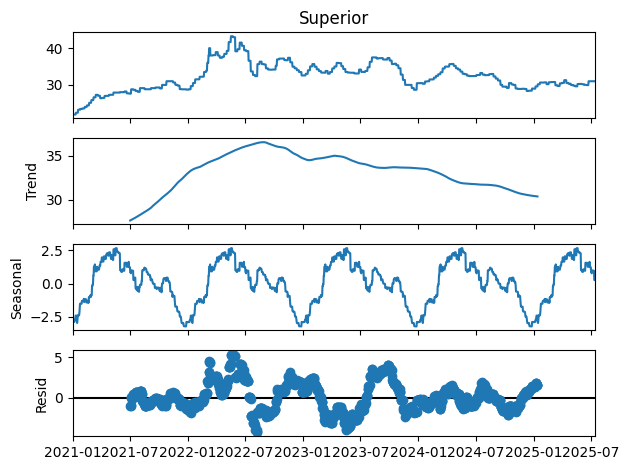

In [891]:
descomposicion = seasonal_decompose(df_final["Superior"], period=365)
descomposicion.plot();

Este segundo gráfico muestra como la media y varianza móvil distan mucho ser consante al verse afectada por los valles y picos causados por la pandemia y la guerra.

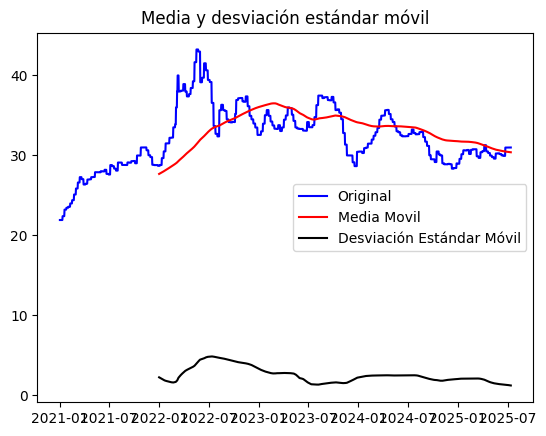

In [892]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = df_final["Superior"].rolling(window=365).mean()
deMovil = df_final["Superior"].rolling(window=365).std()
# Se grafican los resultados.
original = plt.plot(df_final["Superior"], color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

**Frecuencias**

Un análisis de frecuencias por medio de histograma nos revela los precios más frecuentes a lo largo de los 4 se encuentra entre el rango de Q29.00 a Q34.00, además de una distribución no normal.

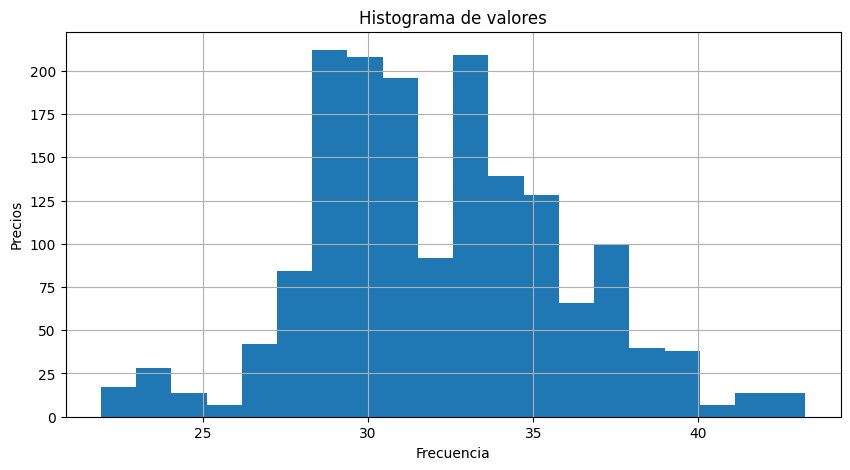

In [893]:
df_final["Superior"].plot(kind="hist", figsize=(10, 5), title="Histograma de valores", bins=20)
plt.xlabel("Frecuencia")
plt.ylabel("Precios")
plt.grid(True)
plt.show()

In [894]:
df_final = df_final[df_final.index.year > 2020]

De los gráficos anteriores se puede disnernir que la serie no parece ser estacionaria ni en media o varianza, un análisis más profundo tendrá que llevarse a cabo.

### Determinación de Estacionaridad

**Estacionaridad en varianza**

De la exploración previa se descubrió que la varianza podría no ser constante, lo cual es confirmado por los 3 tests estadísticos siguientes donde indican heterocedasticidad cuando p < 0.05. Es por ello que se aplicará una transformación de boxcox para suavizar dicha varianza.


In [895]:
resultados = Heteroskedasticity.run_all_tests(df_final['Superior'])
df_results = pd.DataFrame(list(resultados.items()), columns=['Test', 'p-value'])
df_results

,Test,p-value
0,White,4.925573e-50
1,Breusch-Pagan,3.862808e-47
2,Goldfeld-Quandt,6.786014e-55


In [896]:
transformed, fitted_lambda = boxcox(df_final["Superior"])
df_final.loc[df_final.index, "Superior-fixed"] = transformed

Se puede ver una reducción notable en la variana a lo largo de la series antes y después de boxcox.

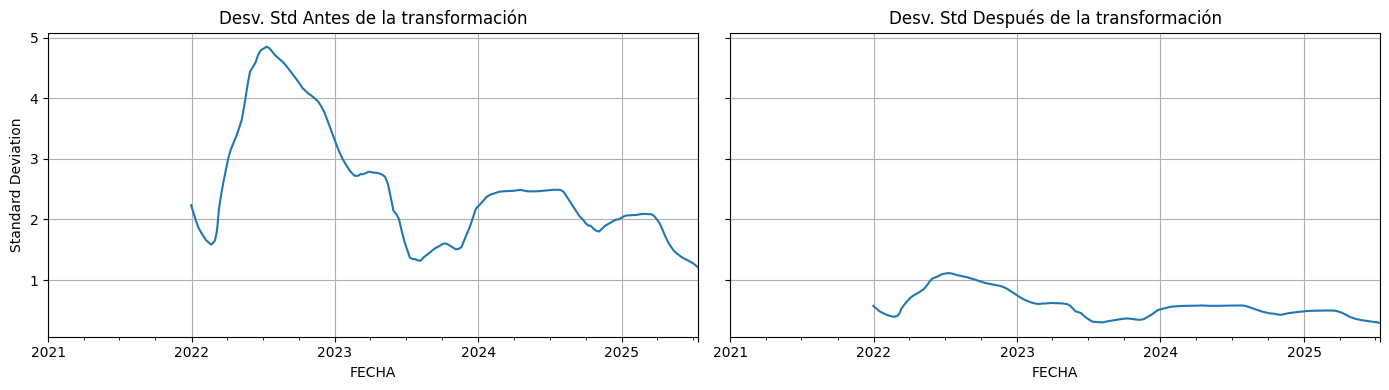

In [897]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# Plot first rolling std dev
df_final['Superior'].rolling(window=365).std().plot(ax=axes[0], title="Desv. Std Antes de la transformación")
axes[0].set_ylabel("Standard Deviation")
axes[0].grid(True)

# Plot second rolling std dev
df_final['Superior-fixed'].rolling(window=365).std().plot(ax=axes[1], title="Desv. Std Después de la transformación")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Sin embargo, los tests siguen siendo fallidos, esto puede ser causado por la variabilidad "artificial" introducida por la pandemia y la guerra. Sin embargo, se mantendrá la transformación dado que la figure previa muestra una atenuación en los picos y valles de la misma.

In [898]:
resultados = Heteroskedasticity.run_all_tests(df_final['Superior-fixed'])
df_results = pd.DataFrame(list(resultados.items()), columns=['Test', 'p-value'])
df_results

,Test,p-value
0,White,1.737177e-55
1,Breusch-Pagan,1.115240e-49
2,Goldfeld-Quandt,1.421570e-52


**Estacionaridad en media**

De lo visto en el análisis exploratorio, la media tampoco se mostraba constante teniendo un ritmo creciente hasta 2022 donde la tendencia se volvio decreciente. Esto es reforzado viendo el correlograma donde la correlación cae lenta y continuamente, siendo indicio de **no estacionariedad en media.**

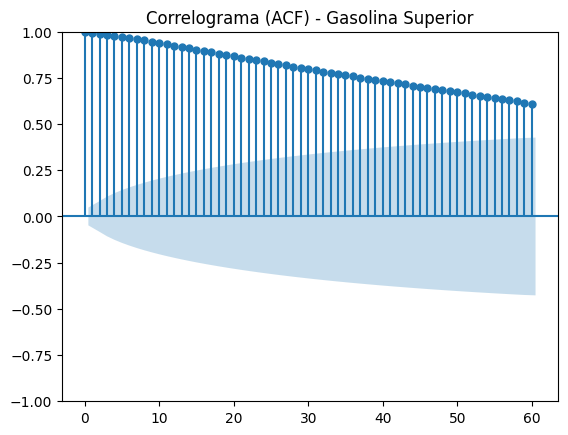

In [899]:
series = df_final["Superior"]

# Plot correlogram (ACF plot)
plot_acf(series, lags=60)
plt.title("Correlograma (ACF) - Gasolina Superior")
plt.show()

Por otro lado, el test de Dicker Fuller al tener un p < 0.05 indica hay estacionaridad en media.

In [900]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(df_final["Superior"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

Resultados del Test de Dickey Fuller


Estadístico de prueba          -3.097852
p-value                         0.026713
# de retardos usados            7.000000
# de observaciones usadas    1647.000000
Critical Value (1%)            -3.434327
Critical Value (5%)            -2.863296
Critical Value (10%)           -2.567705
dtype: float64

Un segundo test estadistitico KPSS, al tener un p < 0.5 da positivo para heterocedasticidad. Juntanto todas las pruebas, se considera que **no estacionaridad en media, por lo que habrá que diferenciar la serie.**

In [901]:
# Run KPSS test
stat, p_value, lags, crit = kpss(df_final["Superior"].values, regression="ct")

# Prepare dictionary
kpss_result = {
    "Test Statistic": stat,
    "p-value": p_value,
    "Lags Used": lags,
    **{f"Critical Value ({k})": v for k, v in crit.items()}
}


df_results = pd.DataFrame(list(kpss_result.items()), columns=['Parametro', 'valor'])
df_results

/tmp/ipykernel_56936/1074177925.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, lags, crit = kpss(df_final["Superior"].values, regression="ct")


,Parametro,valor
0,Test Statistic,0.990497
1,p-value,0.010000
2,Lags Used,26.000000
3,Critical Value (10%),0.119000
4,Critical Value (5%),0.146000
5,Critical Value (2.5%),0.176000
6,Critical Value (1%),0.216000


Tras la diferenciacion, ambos test estadísticos dieron positivo para homocedasticidad. Sin embargo el test KPSS todavía se encuentra cerca de la frontera para ser considerado heterecedastico, así que se podria diferenciar 2 a 4 veces.

In [902]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(df_final["Superior"].diff().dropna(), autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

Resultados del Test de Dickey Fuller


Estadístico de prueba       -1.119726e+01
p-value                      2.290085e-20
# de retardos usados         6.000000e+00
# de observaciones usadas    1.647000e+03
Critical Value (1%)         -3.434327e+00
Critical Value (5%)         -2.863296e+00
Critical Value (10%)        -2.567705e+00
dtype: float64

In [903]:
# Run KPSS test
stat, p_value, lags, crit = kpss(df_final["Superior"].diff().dropna().values, regression="ct")

# Prepare dictionary
kpss_result = {
    "Test Statistic": stat,
    "p-value": p_value,
    "Lags Used": lags,
    **{f"Critical Value ({k})": v for k, v in crit.items()}
}


df_results = pd.DataFrame(list(kpss_result.items()), columns=['Parametro', 'valor'])
df_results

/tmp/ipykernel_56936/3976747430.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_value, lags, crit = kpss(df_final["Superior"].diff().dropna().values, regression="ct")


,Parametro,valor
0,Test Statistic,0.070164
1,p-value,0.100000
2,Lags Used,4.000000
3,Critical Value (10%),0.119000
4,Critical Value (5%),0.146000
5,Critical Value (2.5%),0.176000
6,Critical Value (1%),0.216000


### Generación de modelos

**SARIMAX**

En base a lo estudiado en la sección anterior, la serie será transformada con coxbox seguido de 1 a 3 diferenciaciónes. Sin embargo, primero hay que decidir los valores de `p` y `q` usando las gráficas ACF y PACF.

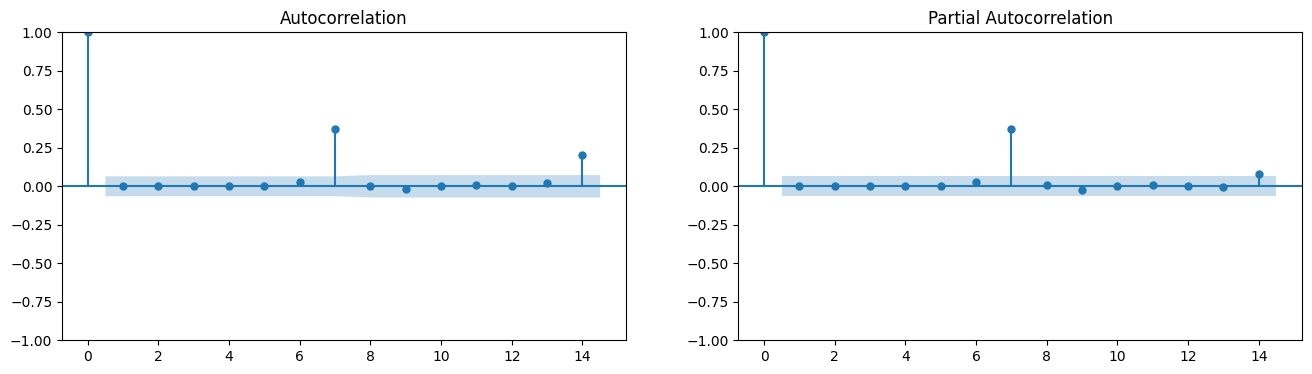

In [904]:
series = df_final[df_final.index.year > 2022]['Superior'].diff().dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(series, lags=14, ax=ax[0])
plot_pacf(series, lags=14, ax=ax[1])
plt.show()

Los gráficos muestran cortes abruptos después del primer retardo, por lo que p=1 y q=1. 

**Estacionariedad**

De los gráficos ACF y PACF anteriores se pueden apreciar pequeños picos que sobresalen cada 7 lags, por lo que se harán unos nuevos gráficos ACF y PACF considerando ese componente estacional. De las nuevas figuras tambien se deduce un corte después de 1 lag P = 1, D = 1.

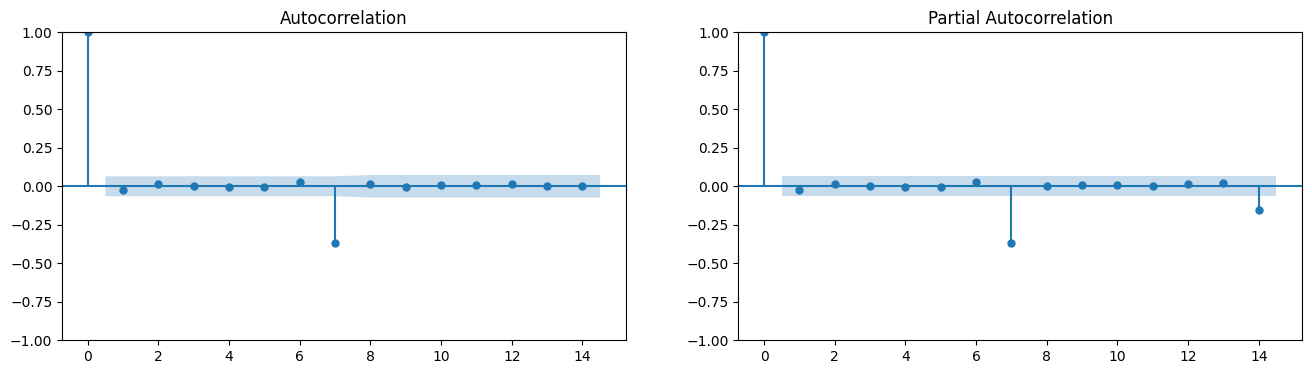

In [905]:
series = df_final[df_final.index.year > 2022]['Superior'].diff().diff(7).dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(series, lags=14, ax=ax[0])
plot_pacf(series, lags=14, ax=ax[1])
plt.show()

Con eso listo, se creo un modelo SARIMAX, con los siguientes resultados:

In [ ]:
df_final["event_2020_2022"] = ((df_final.index >= "2020-01-01") & (df_final.index <= "2022-12-31")).astype(int)

df_train = df_final[(df_final.index.year > 2020) & (df_final.index.year < 2025)]
df_test = df_final[df_final.index.year >= 2025]

exog_train = df_train[["event_2020_2022"]]

modelo121 = SARIMAX(
    df_train['Superior-fixed'], 
    order=(1,2,1), 
    seasonal_order=(0,1,0,7), 
    enforce_stationarity=False, 
    enforce_invertibility=False)
resultado_m121 = modelo121.fit()
print(resultado_m121.summary().tables[1])
print("AIC:", resultado_m121.aic)
print("BIC:", resultado_m121.bic)

/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/smaug/Documents/DataScience/lab1/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0136      0.029     -0.464      0.642      -0.071       0.044
ma.L1         -1.0000      3.456     -0.289      0.772      -7.773       5.773
ar.S.L7       -0.3372      0.007    -50.114      0.000      -0.350      -0.324
sigma2         0.0066      0.023      0.289      0.772      -0.038       0.052
AIC: -3128.4549630260944
BIC: -3107.3542737482835


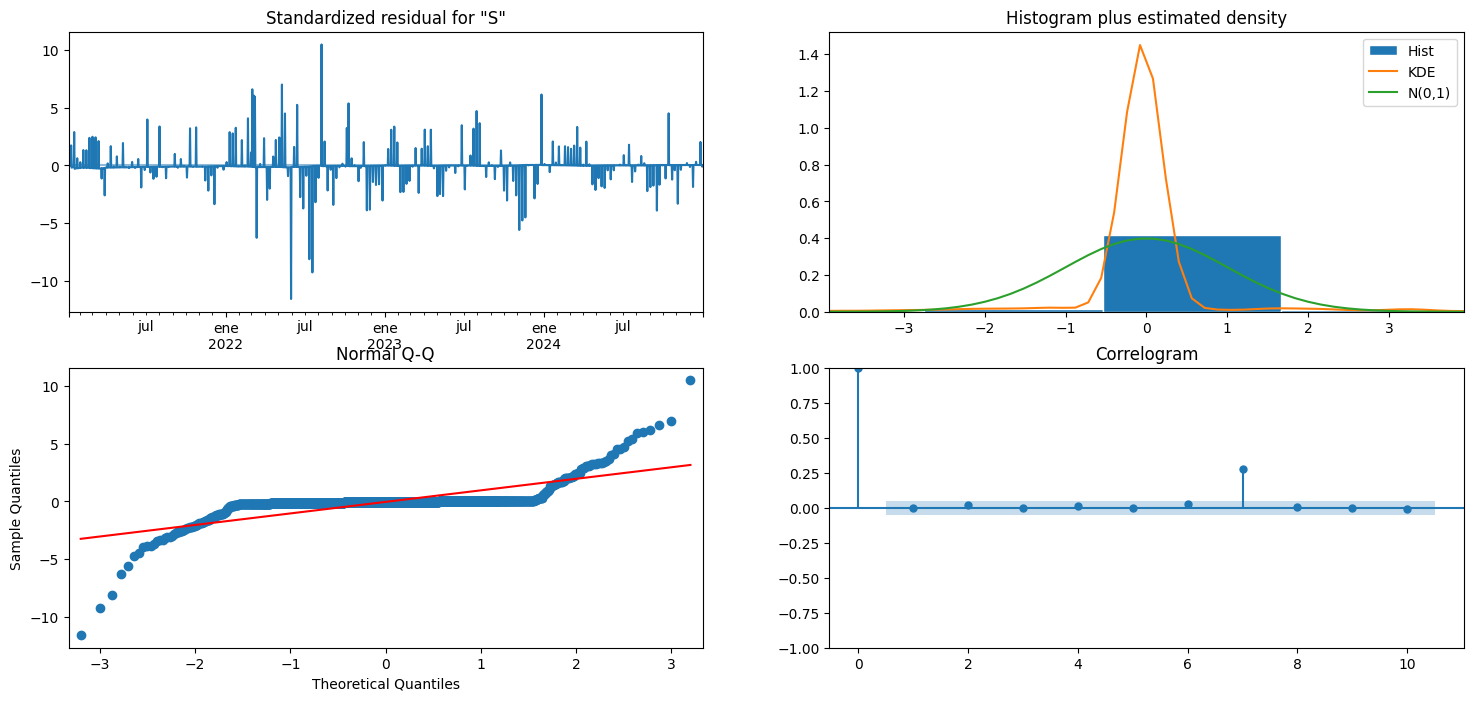

In [924]:
resultado_m121.plot_diagnostics(figsize=(18, 8))
plt.show()

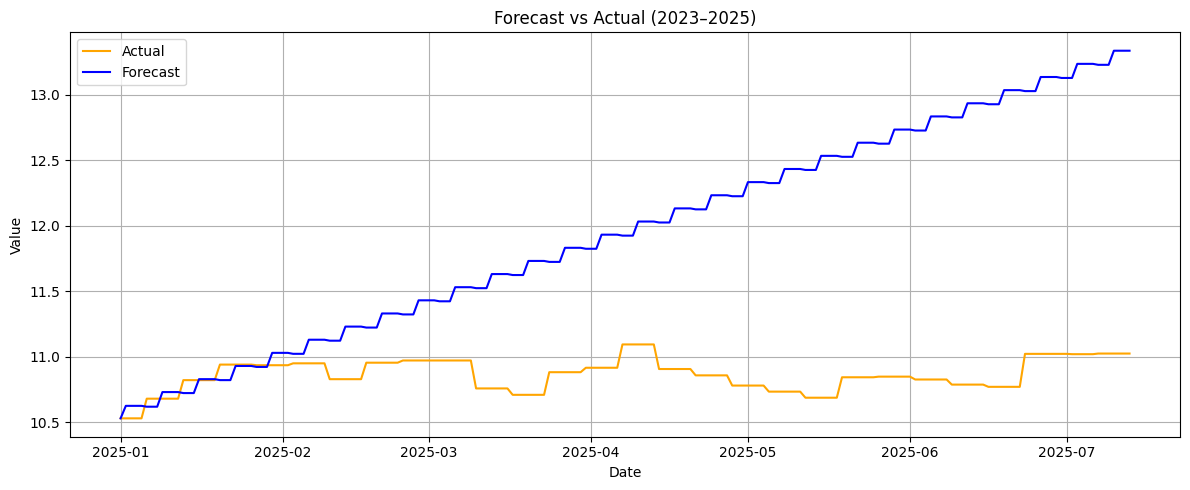

In [930]:
pred = resultado_m121.get_forecast(steps=len(df_test))
predicted_mean = pred.predicted_mean

# Subset predictions and test data to 2023–2025
start_date = "2023-01-01"
end_date = "2025-12-31"

# Filter test set and forecast results
pred_index = df_test.index  # Forecast index matches test set
forecast_series = pd.Series(predicted_mean.values, index=pred_index)
conf_int = pred.conf_int()

# Slice to desired date range
forecast_series = forecast_series[start_date:end_date]
conf_int = conf_int.loc[start_date:end_date]
actual_test = df_test['Superior-fixed'][start_date:end_date]

plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test, label='Actual', color='orange')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='blue')
plt.title("Forecast vs Actual (2023–2025)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Se puede observar que el modelo solo pudo ajustarse durante la primera mitad del mes, 